<h1>Implementation of feature capture technique with adaboost and haar feature algorithm for face detection</h1>

<h3>Original paper "Robust Real-Time Face Detection" by P. Viola and M. Jones</h3>

The article "Robust Real-Time Face Detection" by Paul Viola and Michael Jones presents a highly efficient framework for detecting faces in images, notable for its speed and accuracy. The system introduces three key innovations: the use of an "integral image" representation that allows rapid computation of Haar-like features; a feature selection and classification method based on the AdaBoost algorithm, which identifies a small, effective subset of features from a massive pool; and a cascade structure of classifiers that enables the detector to quickly reject non-face regions and focus computational resources on likely face candidates. This architecture allows the system to process images at around 15 frames per second on standard hardware, making it significantly faster than previous approaches such as those by Rowley et al. or Schneiderman and Kanade. Trained on nearly 5,000 labeled face images, the 38-layer cascade evaluates over 6,000 features but typically uses only 8 per sub-window due to early-stage rejection. Experimental results on the MIT + CMU dataset demonstrate detection rates as high as 94.1% with low false positives, further improved by a simple ensemble voting strategy. While the detector performs well in a range of real-world conditions, it struggles with rotated or occluded faces and extreme lighting. Its speed and simplicity make it suitable for real-time applications in user interfaces, surveillance, and mobile or embedded devices.

<h3>Library import</h3>

In [1]:
import sys
sys.path.append("src")
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

#internal functions
from src.integral_image import compute_integral_image
from src.haar_feature import HaarFeature
from src.weak_classifier import WeakClassifier
from src.adaboost import AdaBoost
from src.generate_features import generate_features



<h2>Data Plot</h2>

First we display two datasets used in order to conduct training process. Both datasets are groups of 24x24 images scaled down for performance purposes. One dataset contains data of different human faces, the other noisy pictures without specific pattern. Our goal is to implement the classifier able to differ faces from other objects.

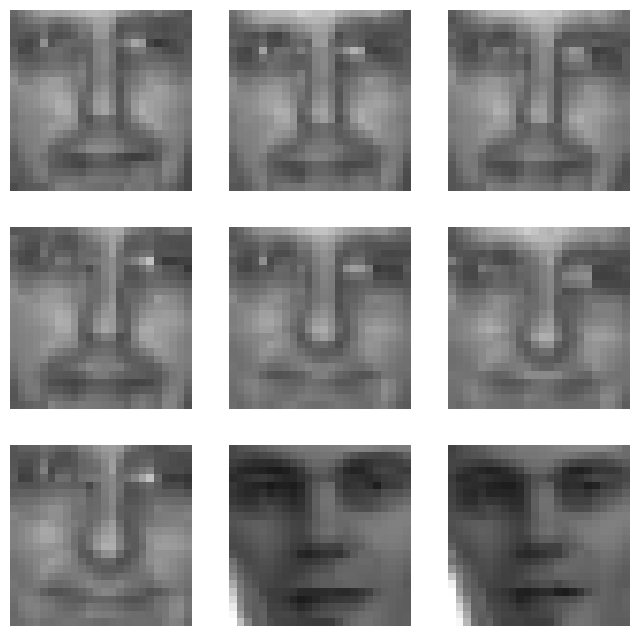

In [2]:
import cv2
fig = plt.figure(figsize=(8, 8))
h=10
w=10
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    im = cv2.imread(f'./data/face/face0000{i}.pgm')
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(im)

plt.show()

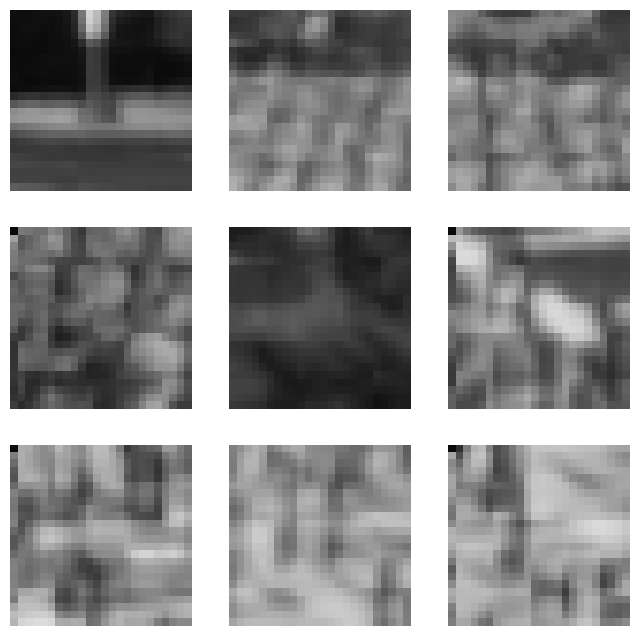

In [24]:
import cv2
fig = plt.figure(figsize=(8, 8))
h=10
w=10
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    im = cv2.imread(f'./data/non-face/B1_0000{i}.pgm')
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(im)

plt.show()

<h2>Integral Computation Step</h2>
<h3>Image processing from both face and non-face data for diversity of training process</h3>

In [3]:
face_paths = glob("data/face/*.pgm")
faces = []

for path in face_paths:
    img = Image.open(path).convert('L')    
    img_array = np.array(img)            
    integral = compute_integral_image(img_array)
    faces.append(integral)

nonface_paths = glob("data/non-face/*.pgm")
nonfaces = []

for path in nonface_paths:
    img = Image.open(path).convert('L')
    img_array = np.array(img)
    integral = compute_integral_image(img_array)
    nonfaces.append(integral)

X = faces + nonfaces
y = np.array([1] * len(faces) + [0] * len(nonfaces))


In [4]:
X_small = X[:200]
y_small = y[:200]

<h2>Feature Generation Step</h2>
<h3>In order to prepare features for final training, we loop through all pixels. At the end of each loop we apply Haare Algorithm and compute region sums. </h3>

The Haar feature selection algorithm for images, used prominently in the Viola-Jones face detection framework, identifies the most informative visual features by combining simple rectangular patterns, integral images, and the AdaBoost learning algorithm. Haar-like features measure intensity differences between adjacent regions in an image and come in various forms, such as two-rectangle, three-rectangle, and four-rectangle patterns, capturing edges, lines, and texture contrasts. These features are computed efficiently using an integral image, which allows any rectangular region sum to be calculated in constant time, drastically reducing computation. Given the vast number of potential features within a detection window, AdaBoost is employed to select only the most relevant ones. In each round of boosting, AdaBoost evaluates all features to find the one that best separates positive (e.g., faces) from negative (non-face) examples, adjusts the sample weights to focus on misclassified instances, and builds a strong classifier from a small set of these weak learners. The result is a fast, accurate classifier that uses a minimal number of critical features from a much larger pool, making it highly effective for real-time image detection tasks.

In [5]:
class HaarFeature:
    def __init__(self, feature_type, position, width, height):
        self.feature_type = feature_type  # 'two-rectangle'
        self.position = position  # (x, y)
        self.width = width
        self.height = height

    def compute_value(self, integral_img):
        x, y = self.position
        w, h = self.width, self.height

        if self.feature_type == 'two-rectangle-horizontal':
            A = self.sum_region(integral_img, x, y, w // 2, h)
            B = self.sum_region(integral_img, x + w // 2, y, w // 2, h)
            return A - B
        elif self.feature_type == 'two-rectangle-vertical':
            A = self.sum_region(integral_img, x, y, w, h // 2)
            B = self.sum_region(integral_img, x, y + h // 2, w, h // 2)
            return A - B
        elif self.feature_type == 'three-rectangle-horizontal':
            A = self.sum_region(integral_img, x, y, w //3, h)
            B = self.sum_region(integral_img, x + w // 3, y, w // 3, h)
            C = self.sum_region(integral_img, x + 2*(w // 3), y, w // 3, h)
            return A - B + C
        elif self.feature_type == 'three-rectangle-vertical':
            A = self.sum_region(integral_img, x, y, w, h // 3)
            B = self.sum_region(integral_img, x, y + h // 3, w, h // 3)
            C = self.sum_region(integral_img, x, y + 2*(h // 3), w, h // 3)
            return A - B + C
        elif self.feature_type == 'four-rectangle':
            A = self.sum_region(integral_img, x, y, w // 2, h // 2)
            B = self.sum_region(integral_img, x + w // 2, y, w // 2, h // 2)
            C = self.sum_region(integral_img, x, y + h // 2, w // 2, h // 2)
            D = self.sum_region(integral_img, x + w // 2, y + h // 2, w // 2, h // 2)
            return A - B - C + D
        else:
            return 0

    def sum_region(self, integral_img, x, y, w, h):
        A = integral_img[y-1, x-1] if y > 0 and x > 0 else 0
        B = integral_img[y-1, x+w-1] if y > 0 else 0
        C = integral_img[y+h-1, x-1] if x > 0 else 0
        D = integral_img[y+h-1, x+w-1]
        return D - B - C + A

In [6]:
def generate_features(window_size = 24):
    features = []
    
    for feature_type in ['two-rectangle-horizontal','two-rectangle-vertical','three-rectangle-horizontal','three-rectangle-vertical','four-rectangle']:
        for w in range (1, window_size + 1):
            for h in range(1, window_size + 1):
                for x in range(0, window_size - w + 1):
                    for y in range(0, window_size - h + 1):
                        feature = HaarFeature(feature_type, (x, y), w, h)
                        features.append(feature)
    return features

In [7]:
features = generate_features()
print("Number of features:", len(features))

Number of features: 450000


In [8]:
import random

features_all = generate_features()
features = random.sample(features_all, 500)


<h2>AdaBoost algorithm</h2>

It's a machine learning ensemble algorithm that has been effectively used in image detection tasks, particularly in object detection such as face recognition. It operates by combining multiple weak classifiers—typically simple decision stumps—into a single strong classifier. AdaBoost selects the most discriminative features by iteratively focusing on examples that were misclassified in previous rounds, adjusting their weights so subsequent classifiers concentrate on harder cases. This results in a final strong classifier that is a weighted combination of a small number of the most effective weak classifiers. To enhance performance and speed, especially for real-time applications, a cascade of classifiers is used: early stages quickly eliminate negative regions of the image (e.g., areas without a face), while later stages apply more complex checks to reduce false positives. This approach, famously implemented in the Viola-Jones face detection framework, enables fast and accurate object detection by focusing computational effort only where it's most needed.

In [9]:
class WeakClassifier:
    def __init__(self, feature, threshold, polarity):
        self.feature = feature
        self.threshold = threshold
        self.polarity = polarity

    def predict(self, integral_img):
        feature_value = self.feature.compute_value(integral_img)
        return 1 if self.polarity * feature_value < self.polarity * self.threshold else 0

In [10]:
import numpy as np

class AdaBoost:
    def __init__(self, num_classifiers):
        self.num_classifiers = num_classifiers
        self.strong_classifier = []

    def train(self, training_data, labels, features):
        num_samples = len(training_data)
        weights = np.ones(num_samples) / num_samples

        for _ in range(self.num_classifiers):
            best_classifier = None
            best_error = float('inf')
            best_pred = None

            for feature in features:
                values = [feature.compute_value(img) for img in training_data]
                thresholds = np.linspace(min(values), max(values), 10)
                for threshold in thresholds: 
                    for polarity in [1, -1]:
                        classifier = WeakClassifier(feature, threshold, polarity)
                        predictions = np.array([classifier.predict(img) for img in training_data])
                        if np.any(predictions == None):
                            continue
                        error = np.sum(weights * (predictions != labels))
                        if error < best_error:
                            best_error = error
                            best_classifier = classifier
                            best_pred = predictions
            if best_classifier is None or best_pred is None:
                continue
            epsilon = 1e-10
            alpha = 0.5 * np.log((1 - best_error) / (best_error + epsilon))
            weights *= np.exp(-alpha * labels * (2 * best_pred - 1))
            weights /= np.sum(weights)

            self.strong_classifier.append((alpha, best_classifier))

    def predict(self, integral_img):
        total = sum(alpha * (2 * clf.predict(integral_img) - 1)
                    for alpha, clf in self.strong_classifier)
        return 1 if total >= 0 else 0

<h2>Training on the data</h2>

For the model of AdaBoost defined with different features with conduct training process that was hard-coded into the class of AdaBoost Algorithm.

In [11]:
model = AdaBoost(num_classifiers=5)
model.train(X, y, features)


<h2>Prediction Step</h2>

In order to implement trained model and see how accurately it predicts the data, we can roll through the data and try to capture if the predicted image is face or not.

In [12]:
y_pred = []

for i in range(500):
    true_label = y[i]
    pred = model.predict(X[i])
    y_pred.append(pred)
    print(f"Example Image {i}: Prediction = {pred}, Label = {true_label}")

Example Image 0: Prediction = 1, Label = 1
Example Image 1: Prediction = 1, Label = 1
Example Image 2: Prediction = 0, Label = 1
Example Image 3: Prediction = 0, Label = 1
Example Image 4: Prediction = 1, Label = 1
Example Image 5: Prediction = 0, Label = 1
Example Image 6: Prediction = 0, Label = 1
Example Image 7: Prediction = 1, Label = 1
Example Image 8: Prediction = 1, Label = 1
Example Image 9: Prediction = 1, Label = 1
Example Image 10: Prediction = 1, Label = 1
Example Image 11: Prediction = 1, Label = 1
Example Image 12: Prediction = 1, Label = 1
Example Image 13: Prediction = 0, Label = 1
Example Image 14: Prediction = 1, Label = 1
Example Image 15: Prediction = 1, Label = 1
Example Image 16: Prediction = 1, Label = 1
Example Image 17: Prediction = 0, Label = 1
Example Image 18: Prediction = 0, Label = 1
Example Image 19: Prediction = 0, Label = 1
Example Image 20: Prediction = 1, Label = 1
Example Image 21: Prediction = 1, Label = 1
Example Image 22: Prediction = 1, Label = 

<h2>Percentage of correctly predicted values</h2>

In [36]:
round(y_pred.count(1) / 500 * 100, 2)

69.4

<h2>Percentage of incorrectly predicted values</h2>

In [37]:
round(y_pred.count(0) / 500 * 100, 2)

30.6

<h2>Alternatives to Robust Haare Algorithm</h2>

Several algorithms serve as alternatives to Haar-like features for image-based object detection and classification, each offering different strengths in terms of accuracy, speed, and robustness. One popular alternative is the Histogram of Oriented Gradients (HOG), which captures edge orientation and gradient patterns and is widely used for pedestrian detection due to its robustness to lighting and deformation. Local Binary Patterns (LBP) provide a simple, fast method for capturing local texture by comparing pixel intensities and are often used in face recognition, although they can be sensitive to noise. More advanced techniques like SIFT (Scale-Invariant Feature Transform) and SURF (Speeded-Up Robust Features) extract distinctive keypoints invariant to scale and rotation, making them effective for matching and recognition, though they are computationally heavier than Haar or LBP. Gabor filters, inspired by human visual processing, are excellent for texture and biometric recognition tasks but are computationally intensive. In modern computer vision, Convolutional Neural Networks (CNNs) have largely surpassed traditional hand-crafted features by automatically learning hierarchical representations from data, achieving state-of-the-art performance in detection and classification, albeit requiring significant computational power and training data. Additionally, edge and contour-based features are useful in shape-focused tasks but tend to be less robust to occlusions or noise. Each method offers trade-offs, making the choice of algorithm dependent on the specific application requirements, such as speed, accuracy, and hardware constraints.